### Experiments with U-Net on collection of cat images

Try U-Net following [Xiantao et al., 2020](https://www.nature.com/articles/s41598-020-59801-x), but with only 4 convolutions, opposed to 5.
Work with collection of grayscale cat images.

Choose **mask type**: Can either have random sparsity mask, individually for each data sample ('variable'), or create only a single random mask, that is then applied to all samples identically ('fixed'). 
And optionally extend data with **augmentation factor**: Specify the number of times, each sample is to be cloned, keeping the original order.

#### Experiments:

1) **mask_type='variable', augmentation_factor=1:** Extends base experiment, can handle variable inputs with fixed sparsity in single model. Fits to observations from e.g. argo floats on their trajectory or well suited for e.g. sea surface temperature measurements, where varying cloud coverage limits infrared observations. In its simples form, use each sample only once. Expect worse performance, commpared to base experiment.
2) **mask_type='variable', augmentation_factor>0:** Improve performance by using each input sample multiple times, allowed by random sparsity. Try to reduce overfitting and increase generalization on unseen data. Comes at the expense of increased training time.

Use **sparse and scaled (to [0,1]) samples as inputs**. Use **complete and scaled (to [0,1]) samples as targets**.

In [1]:
import os
import sys
sys.path.append('../reconstruct_missing_data')

from pathlib import Path
from json import dump, load

import numpy as np
from matplotlib import pyplot as plt

from data_loading import clone_data, create_missing_mask, split_and_scale_data

In [2]:
# Set working directory, according to working directory in scripts:
os.chdir('/gxfs_work1/geomar/smomw511') # nesh
# os.chdir('/Users/mlandt-hayen') # local

In [3]:
## Specify base parameters for experiments to compare:

# exp1: variable mask, augmentation factor 1
# exp2: variable mask, augmentation factor 3

# Common parameters for all experiments:
model_config = 'unet_4conv'
source = 'cats_1300' # Choose Earth System Model, either 'FOCI' or 'CESM', or 'realworld'.

# Specific parameters for exp1:
mask_types = ['variable',]#
missing_types = ['discrete',]#'discrete','discrete']
augmentation_factors = [1,]#1,1]
runs = ['_seed_1',]# '_seed_2', '_seed_3']

# Reconstruct path to experiment:
paths = []
for i in range(len(mask_types)):
    paths.append(Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+source+'_'
                      +mask_types[i]+'_'+missing_types[i]+'_factor_'+str(augmentation_factors[i])+runs[i]))
    print(paths[i])

# Initialize storage for parameters of all experiments:
parameters_all = []

# Reload parameters for all experiments:
for path in paths:
    
    # Open corresponding parameter file and store:
    with open(path / 'parameters.json', 'r') as f:
        parameters_all.append(load(f))

# Convert to numpy array:
parameters_all = np.array(parameters_all)

# Extract certain parameters from first experiment. Note: These parameters should be identical for all experiments of interest, here.
train_val_split = parameters_all[0]['train_val_split']
missing_values = parameters_all[0]['missing_values']
scale_to = parameters_all[0]['scale_to']
epochs = parameters_all[0]['epochs']

## Get an overview of final train and validation loss, depending on rel. amount of missing values, for all experiments.
## Note: Start with epoch 0, hence untrained model.

# Initialize storage for final train and validation loss. Dimension: (#experiments, #missing values settings, #epochs+1)
train_loss_final_all = np.zeros((len(paths),len(missing_values),epochs+1))
val_loss_final_all = np.zeros((len(paths),len(missing_values),epochs+1))

# Loop over experiments:
for i in range(len(paths)):
    
    # Get path for current experiment:
    path = paths[i]

    # Loop over array of desired rel. amounts of missing values:
    for j in range(len(missing_values)):

        # Get current sparsity:
        missing = missing_values[j]

        # Reload loss.
        # Rel. amount of missing values = 0.999 requires special treatment:
        if missing==0.999:
            train_loss = np.load(path / 'missing_' f'{int(missing*1000)}'/ 'train_loss.npy')
            val_loss = np.load(path / 'missing_' f'{int(missing*1000)}'/ 'val_loss.npy')
        else:
            train_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'train_loss.npy')
            val_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'val_loss.npy')
            
        # Store final train and validation loss:
        train_loss_final_all[i,j,:] = train_loss
        val_loss_final_all[i,j,:] = val_loss
        
# Get minimum train and validation loss over epochs for experiment 1:
train_loss_min_exp1 = np.min(train_loss_final_all,axis=-1)
val_loss_min_exp1 = np.min(val_loss_final_all,axis=-1)

# Get mean and std dev of minimum train and validation loss over all runs:
train_loss_min_mean_exp1 = np.mean(train_loss_min_exp1,axis=0)
val_loss_min_mean_exp1 = np.mean(val_loss_min_exp1,axis=0)
train_loss_min_std_exp1 = np.std(train_loss_min_exp1,axis=0)
val_loss_min_std_exp1 = np.std(val_loss_min_exp1,axis=0)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_cats_1300_variable_discrete_factor_1_seed_1


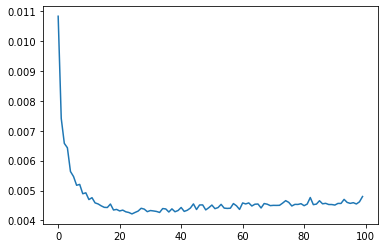

In [7]:
# Inspect validation loss, whether we see minimum:
plt.plot(val_loss_final_all[0,3,1:])

In [6]:
# Find epochs with lowest validation loss for each rate of missing values:
np.argmin(val_loss_final_all[0],axis=-1)

array([20, 17, 17, 25, 58, 85])

In [ ]:
# Manually stored only models after min-epoch for each rate of missing values.

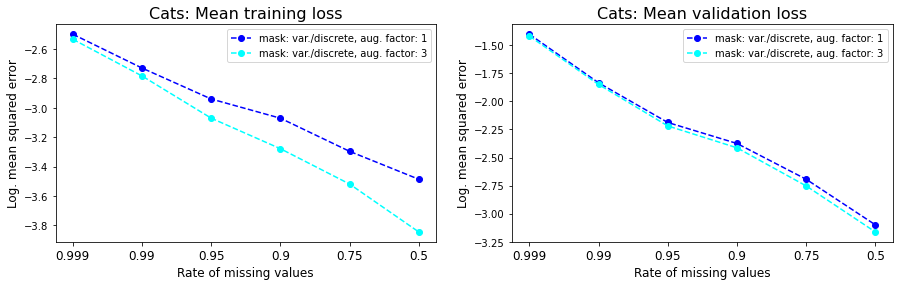

In [5]:
# Set colors for individual experiments:
colors = ['blue', 'red', 'cyan']
linestyles = ['--', '--', '--']

# Plot final train and validation loss over sparsity for all experiments:
fig, axes = plt.subplots(1,2,figsize=(15,4))

# exp1:
axes[0].plot(
        np.log10(train_loss_min_mean_exp1), color=colors[0],
        label = 'mask: var./discrete, aug. factor: 1',
        marker = 'o', linestyle = linestyles[0],
    )

axes[1].plot(
        np.log10(val_loss_min_mean_exp1), color=colors[0],
        label = 'mask: var./discrete, aug. factor: 1',
        marker = 'o', linestyle = linestyles[0],
    )

# exp2:
axes[0].plot(
        np.log10(train_loss_min_mean_exp2), color=colors[2],
        label = 'mask: var./discrete, aug. factor: 3',
        marker = 'o', linestyle = linestyles[2],
    )

axes[1].plot(
        np.log10(val_loss_min_mean_exp2), color=colors[2],
        label = 'mask: var./discrete, aug. factor: 3',
        marker = 'o', linestyle = linestyles[2],
    )

# #plt.ylim(0.6, 0.8)
axes[0].set_xticks(np.arange(0, len(missing_values), step=1), missing_values, fontsize=12)
axes[1].set_xticks(np.arange(0, len(missing_values), step=1), missing_values, fontsize=12)
axes[0].set_title('Cats: Mean training loss', fontsize=16)
axes[1].set_title('Cats: Mean validation loss', fontsize=16)
axes[0].set_xlabel('Rate of missing values', fontsize=12)
axes[1].set_xlabel('Rate of missing values', fontsize=12)
axes[0].set_ylabel('Log. mean squared error', fontsize=12)
axes[1].set_ylabel('Log. mean squared error', fontsize=12)
axes[0].legend()
axes[1].legend()
plt.show() 